# Titanic: Machine Learning from Disaster

The goal of this model is given set of features to predict if passanger survived the trangedy of RMS Titanic in 1912.

I have done no research on other participant contributions to not get biased towards their solutions and try something completely of my own.

## Data ##
**Dataset:** 891 data points, 10 features, 1 label
**Test set:** 418 data points, 10 features

**Features**:
- Class of travel
- Name
- Gender
- Age
- Number of Sibling/Spouse aboard
- Number of Parent/Child aboard
- Ticket
- Fare
- Cabin
- Embarked

Not all passangers have all features. Also some features such as Name, Ticket or Cabin do not have standardized format.

**Labels**:
- Survived: 1 if passanger survived the tragedy, 0 if not

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

In [3]:
# Load dataset
dataset = pd.read_csv("dataset/train.csv")

In [4]:
dataset.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [5]:
print("#samples: "+str(dataset.shape[0]))
print("#features: "+str(dataset.shape[1]-2)) # -2 for Id and label

#samples: 891
#features: 10


All features might not be present in all examples:

In [6]:
print(dataset.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


Balance of the dataset:

In [7]:
num_of_survived = dataset[dataset.Survived == 1].Survived.count()
num_of_not_survived = dataset.shape[0]-num_of_survived
print("Passangers that survived: %d, %.2f%%" % (num_of_survived,  num_of_survived/dataset.shape[0]*100))
print("Passangers that did not survived: %d, %.2f%%" % (num_of_not_survived,  num_of_not_survived/dataset.shape[0]*100))

Passangers that survived: 342, 38.38%
Passangers that did not survived: 549, 61.62%


## Feature analysis ##

For the first, simplest model, lets focus on features that do not need a lot of preprocessing. Thus we ommit Name, Ticket and Cabin.

Name feature could give us information about wealth of the passanger, however we already receive the Class of travel which should be good indicator and we might need much bigger dataset to extract such information from the dataset.

Cabin feature could be very helpful, however Cabin information is present in only 204 samples, is unique (would need preprocessing to add information about the location of the cabin) and some passangers have more than 1.

Ticket feature might give similar information as Cabin and Class of travel, but similarly as in Cabin needs research to extract useful information and preprocessing since it does not always have standardized format.

**Class of travel**

Contains information about wealth of the passanger and likely position of the cabin on the ship.

It can take value from 1,2 or 3 from 1 being the most luxurious. Lets see the distribution in the dataset:

In [8]:
dataset.groupby(['Survived', 'Pclass'])["Pclass"].count()

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Pclass, dtype: int64

From numbers above it can be seen that only 1/4 of passangers in 3rd class in the dataset survived, however more than 3/5 of passangers in 1st class survived. Showing that Class of travel is possibly good feature.

**Gender**

Gender is potentially very usefull feature considering RMS Titanic being famous for the phrase "Woman and children first". According to blog post (https://blog.minitab.com/blog/real-world-quality-improvement/analyzing-titanic-survival-rates) which analyzed available data 73% of female passangers survived and only 21% of male passangers did.

Lets see the distribution in our dataset:

In [9]:
dataset.groupby(['Survived', 'Sex'])["Sex"].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

In [10]:
print("Female survived: %.2f%%, Male survived: %.2f%%" % (233/(81+233)*100, 109/(109+468)*100))

Female survived: 74.20%, Male survived: 18.89%


**Age**

I suspect Age to be partially missledaing. Firstly, I lack knowledge about the policy that took place considering age - if they prioritized elderly or young. However even if prioritization would go towards elderly, they might be more prone to not being able to get to lifeboats in time.

Again, lets look at the distribution:

In [11]:
dataset[dataset["Survived"]==0]["Age"].hist(bins=8)

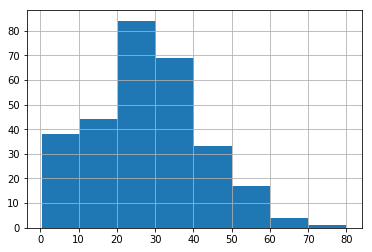

In [12]:
dataset[dataset["Survived"]==1]["Age"].hist(bins=8)

Distributions seem very similar, however one can notice significantly higher group of younger passangers survived and signifantly higher group of older passangers did not. This suggests children were priority.

**Number of Sibling/Spouse aboard and Number of Parent/Child aboard**

These features might not seem valuable at first, however if it is true that male passangers were let on the lifeboats if they had children or maybe with their spouse/whole family. Lets look at few histograms that might give us some idea.

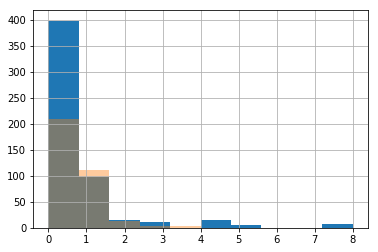

In [13]:
dataset[dataset["Survived"]==0]["SibSp"].hist(bins=10)
dataset[dataset["Survived"]==1]["SibSp"].hist(bins=5, alpha=0.4)


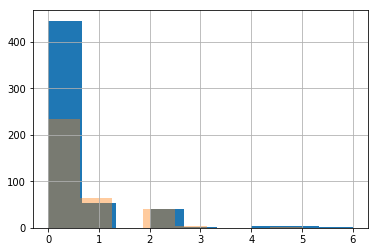

In [14]:
dataset[dataset["Survived"]==0]["Parch"].hist(bins=9)
dataset[dataset["Survived"]==1]["Parch"].hist(bins=8, alpha=0.4)

In [15]:
dataset[(dataset["Survived"]==0) & (dataset["SibSp"]>0) & (dataset["Parch"]>0)]["Survived"].count()

80

In [16]:
dataset[(dataset["Survived"]==1) & (dataset["SibSp"]>0) & (dataset["Parch"]>0)]["Survived"].count()

62

Having a lot of siblings/spouses and children/parents aboard (>4) seems to be bad for your survival chances. It makes sense since you are more likely to refuse board lifeboat when your family is not together or you are not all allowed to board the lifeboat together.

Idea that having more than 0 from both categories, thus traveling with family, might be positive seems to be false since more of those passangers died than survived.

**Embarked**

The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown. My assumption is this feature has no influence. If the analysis confirms the distribution is close to uniform I shall ommit this feature.

In [17]:
dataset.groupby(['Survived', 'Embarked'])["Embarked"].count()

Survived  Embarked
0         C            75
          Q            47
          S           427
1         C            93
          Q            30
          S           217
Name: Embarked, dtype: int64

In [18]:
print("Survived - S:%.2f%% C:%.2f%% Q:%.2f%%" % (217/(427+217),93/(75+93),30/(30+47)))

Survived - S:0.34% C:0.55% Q:0.39%


In [19]:
dataset.groupby(['Embarked', 'Pclass'])["Pclass"].count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Pclass, dtype: int64

It seems that passangers traveling from Cherbough which was 2nd out of 3 boarding places had higher chance of survival than passangers boarding on the other. This correlates with Pclass since there is high percentage of passangers from 1st class that boarded on this stop. I will keep it in the dataset but might try to ommit it.

**Fare**

Fare feature will most likely be very correlated with Pclass. Lets see if that is true.

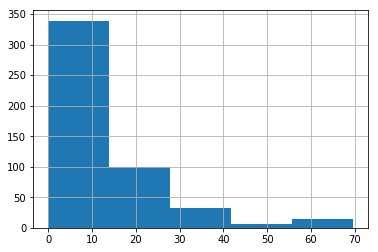

In [20]:
dataset[dataset["Pclass"]==3]["Fare"].hist(bins=5)

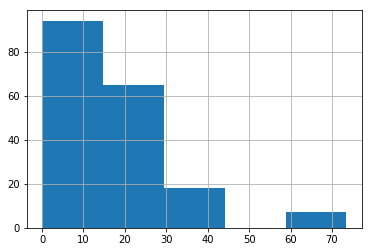

In [21]:
dataset[dataset["Pclass"]==2]["Fare"].hist(bins=5)

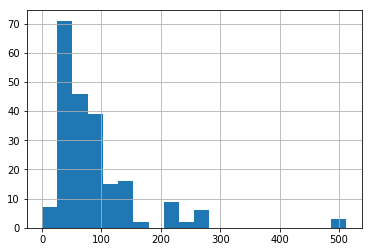

In [22]:
dataset[dataset["Pclass"]==1]["Fare"].hist(bins=20)

Even tough the there are some passangers that payed similar Fare in 3rd and 1st class, there seems to be visible correlation.

**Conclusion**

I think Pclass, Sex and Age are the features that give us the most information. We will try few classifiers with different set of features, however these 3 should always be present.

## Dataset preprocessing ##

Lets select only features we decided to use now and normalize them.

In [23]:
dataset_red = dataset[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch","Fare", "Embarked"]]

In [24]:
mapping_sex = {'male': 0, 'female': 1}
mapping_embarked = {'S': 0, 'C': 1, 'Q': 2}
dataset_red = dataset_red.applymap(lambda s: mapping_sex.get(s) if s in mapping_sex else s)
dataset_red = dataset_red.applymap(lambda s: mapping_embarked.get(s) if s in mapping_embarked else s)

In [25]:
dataset_red_norm = dataset_red.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataset_red_norm["Survived"] = dataset_red["Survived"]
dataset_red_norm = dataset_red_norm.fillna(value='0')

## Training classical classifiers ##

**Split data**

In [26]:
train, test = train_test_split(dataset_red_norm, test_size=0.2)
y_train = train["Survived"]
x_train = train.loc[:, train.columns != 'Survived']
y_test = test["Survived"]
x_test = test.loc[:, test.columns != 'Survived']

**Logistic regression**

In [27]:
logreg_clf = LogisticRegression(max_iter=100, penalty='l2', solver="lbfgs", tol=1e-10)
logreg_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=1e-10, verbose=0, warm_start=False)

In [28]:
logreg_clf.score(x_train, y_train)

0.8103932584269663

In [29]:
logreg_clf.score(x_test, y_test)

0.7430167597765364

In [30]:
logreg_clf.predict(x_test.iloc[range(20),:]) == y_test.iloc[range(20)].values

array([False,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True])

**SVM**

In [31]:
svm_clf = svm.SVC(gamma='auto', kernel='rbf', C=1000)

In [32]:
svm_clf.fit(x_train,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
svm_clf.score(x_train, y_train)

0.8398876404494382

In [34]:
svm_clf.score(x_test, y_test)

0.8156424581005587

In [35]:
svm_clf.predict(x_test.iloc[range(20),:]) == y_test.iloc[range(20)].values

array([False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True])

**AdaBoost**

In [48]:
best_depth = None
best_num_clas = None
best_lr = None
best_test_score = 0

counter = 0
for depth in range(2,10):
    for est_num in np.logspace(1,2.9,20):
        est_num = int(np.round(est_num))
        for lr in np.logspace(-3,1,25):
            ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=est_num, learning_rate=lr)
            ada_clf.fit(x_train,y_train)
            curr_score = ada_clf.score(x_test, y_test)
            counter += 1
            if counter%20==0:
                print("Working... iteration: %i" % (counter))
            if curr_score > best_test_score:
                best_test_score = curr_score
                best_depth = depth
                best_num_clas = est_num
                best_lr = lr
                print("Best Found new best parameters: - depth:%d - num_est:%d - lr:%.4f\n Best test score:%.4f" % (best_depth, best_num_clas, best_lr, curr_score))

print("Best parameters - depth:%d - num_est:%d - lr:%.2f" % (best_depth, best_num_clas, best_lr))
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), n_estimators=best_num_clas, learning_rate=best_lr)
ada_clf.fit(x_train,y_train)                

Best Found new best parameters: - depth:2 - num_est:10 - lr:0.0010
 Best test score:0.7542
Best Found new best parameters: - depth:2 - num_est:10 - lr:0.1468
 Best test score:0.7877
Best Found new best parameters: - depth:2 - num_est:10 - lr:0.2154
 Best test score:0.8101
Working... iteration: 20
Working... iteration: 40
Best Found new best parameters: - depth:2 - num_est:13 - lr:1.4678
 Best test score:0.8212
Working... iteration: 60
Working... iteration: 80
Best Found new best parameters: - depth:2 - num_est:20 - lr:0.4642
 Best test score:0.8268
Working... iteration: 100
Working... iteration: 120
Working... iteration: 140
Working... iteration: 160
Working... iteration: 180
Working... iteration: 200
Best Found new best parameters: - depth:2 - num_est:63 - lr:0.3162
 Best test score:0.8324
Best Found new best parameters: - depth:2 - num_est:63 - lr:0.6813
 Best test score:0.8380
Working... iteration: 220
Working... iteration: 240
Working... iteration: 260
Working... iteration: 280
Wor

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.046415888336127774, n_estimators=16,
          random_state=None)

In [49]:
ada_clf.score(x_train, y_train)

0.9283707865168539

In [50]:
ada_clf.score(x_test, y_test)

0.8212290502793296

In [51]:
svm_clf.predict(x_test.iloc[range(20),:]) == y_test.iloc[range(20)].values

array([False,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True])